# Diabetes Prediction

The goal of this project is to build a model that identifies patients that have a diagnosis of Type 2 diabetes mellitus (T2DM). Diagnosis of T2DM is defined by a set of ICD9 codes: {'250', '250.0', 250.*0, and 250.*2} where 250.*0 means '250.00', '250.10', '250.20', ... '250.90' and 250.*2 means '250.02', '250.12', ... '250.92'. Note that ICD9 codes 250.*1 and 250.*3 are for Type I diabetes mellitus and are not to be classified. 

In [136]:
# Load the packages
from pathlib import Path
import glob
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import brier_score_loss

from xgboost.sklearn import XGBClassifier

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

SEED = 42

## Load and Clean Data

In [2]:
# Load the data
patient = pd.read_csv('test_SyncPatient.csv')
training_patient = pd.read_csv('training_SyncPatient.csv')
allergy = pd.read_csv('training_SyncAllergy.csv')
condition = pd.read_csv('SyncCondition.csv')
smoking_status = pd.read_csv('SyncSmokingStatus.csv')
diagnosis = pd.read_csv('training_SyncDiagnosis.csv')
immunization = pd.read_csv('training_SyncImmunization.csv')
lab_observation = pd.read_csv('training_SyncLabObservation.csv')
lab_panel = pd.read_csv('training_SyncLabPanel.csv')
lab_result = pd.read_csv('training_SyncLabResult.csv')
medication = pd.read_csv('training_SyncMedication.csv')
patient_condition = pd.read_csv('training_SyncPatientCondition.csv')
patient_smoking_status = pd.read_csv('training_SyncPatientSmokingStatus.csv')
prescription = pd.read_csv('training_SyncPrescription.csv')
transcript = pd.read_csv('training_SyncTranscript.csv')
transcript_allergy = pd.read_csv('training_SyncTranscriptAllergy.csv')
transcript_diagnosis = pd.read_csv('training_SyncTranscriptDiagnosis.csv')
transcript_medication = pd.read_csv('training_SyncTranscriptMedication.csv')

In [3]:
# extract training_patientID
training_patientID = training_patient.PatientGuid
training_patientID = training_patientID.dropna()

In [4]:
# extract test_patientID
all_patientID = patient[['PatientGuid']]
test_patientID = all_patientID[~all_patientID.isin(training_patientID)]
test_patientID = test_patientID.dropna()
test_patientID = test_patientID['PatientGuid']

In the following part, I will clean and aggregate individual csv files.

### Allergy

In [5]:
allergy.head()

,AllergyGuid,PatientGuid,AllergyType,AllergyStartYear,ReactionName,SeverityName,MedicationNDCCode,MedicationName,UserGuid
0,FFD9BE48-3AD6-40CB-A5CD-001CDCE49A26,43CE4977-3EC1-48D5-8FCE-8F27BBDDFC1C,Medication,2010,Runny nose,Modest,7.443429e+07,TriCor (fenofibrate) oral capsule,60C80223-5A28-4E74-89FF-73505D39BCDD
1,5C0F88CB-1B5A-4EA7-8921-00D777F82918,622830A1-BA4A-4272-B38B-4C6A9D6F973D,Medication,2012,Shortness of breath,Severe,1.780085e+08,Ferrous Fumarate oral tablet,6605B278-A5B4-4CBC-907E-E1E8508E0404
2,D536315B-A551-4CA5-A505-00E553EFCD4D,44BFA67A-9E8E-4447-BFCC-17FF76ADFE21,Medication,2011,Rash - generalized,Mild,6.811503e+10,"Norflex (orphenadrine) oral tablet, extended r...",B7B99AED-10D1-4608-8274-64F66B6FFDB4
3,C0A19E94-FEC2-45C6-9D46-00EBD8F2226C,74F39AC1-16C5-4A9C-BF59-67513C342070,Medication,2011,Diarrhea,Mild,4.562005e+08,Lexapro (escitalopram) oral tablet,2F7B6534-886A-4CC7-958E-2197A1741126
4,D7779B6B-2FFF-4A87-8F74-00F000127A8E,DCFBC6A1-2EBD-41C8-8B17-64D3EC20C082,Medication,2012,Vomiting,Severe,5.801601e+10,Vicodin (acetaminophen-HYDROcodone) oral tablet,D73415A9-CCD2-4D17-A43A-45E75878C6C5


In [6]:
# ordinal encoding 'SeverityName'
severity_map = {'Very Mild': 0, 'Mild': 1, 'Modest': 2, 'Severe': 3}
allergy['EncodedSeverity'] = allergy.SeverityName.map(severity_map)

In [7]:
# derive allergy history
current_year = 2012
allergy['AllergyHistory'] = current_year - allergy['AllergyStartYear']

In [8]:
# groupby PatientGuid
clean_allergy = allergy.groupby('PatientGuid').agg({'AllergyType': 'count', 'ReactionName': 'count', 'MedicationNDCCode': 'count', 'EncodedSeverity': 'mean', 'AllergyHistory': 'mean'})

In [9]:
clean_allergy.reset_index(inplace = True)

In [10]:
clean_allergy.columns = ['PatientGuid', 'AllergyType', 'ReactionType', 'NumOfAllergyMedication', 'AllergySeverity', 'AllergyHistory']

In [11]:
clean_allergy.head()

,PatientGuid,AllergyType,ReactionType,NumOfAllergyMedication,AllergySeverity,AllergyHistory
0,003CEE1F-5BF5-4171-9284-F5464EC12D41,2,2,2,2.5,1.0
1,005F61C9-E537-4AD2-B39C-37F25891F33A,1,1,1,2.0,1.0
2,0063B34F-C2C4-423A-A144-E51F7149253A,2,2,2,3.0,1.0
3,006E3A23-F786-4ED2-BE70-D91D23BA56EA,2,2,2,0.5,1.0
4,00B7C61A-82E5-42E1-B9C0-6B39C5BC552F,1,1,1,1.0,1.0


### PatientCondition and Condition

In [12]:
condition

,ConditionGuid,Code,Name
0,D4FF24EA-658D-4500-A71F-821F9776FB27,NOKNOWNDIAGNOSES,No Known Diagnoses
1,4BF4503F-4EA7-4E63-BBA6-B6A4A8C273F8,NOKNOWNALLERGIES,No Known Allergies
2,2AE517F6-5029-4BC4-9353-FB8E0CC3A822,NOKNOWNMEDICATIONS,No Known Medications


In [13]:
patient_condition.head()

,PatientConditionGuid,PatientGuid,ConditionGuid,CreatedYear
0,22A5A7B5-FF9F-4FE6-86B2-00314970CF94,7441A529-1D78-4807-81F5-77B3D125D375,4BF4503F-4EA7-4E63-BBA6-B6A4A8C273F8,2011
1,F9BE2F6F-87DD-4816-9ADE-00423A35C7DB,026855B2-24AC-4586-9F8C-DAC183CFE913,4BF4503F-4EA7-4E63-BBA6-B6A4A8C273F8,2011
2,61A844C2-01B0-4DBF-B4AE-0062C30CD9B0,6793DFD6-3DE1-41A6-A39E-1E21CE955D79,4BF4503F-4EA7-4E63-BBA6-B6A4A8C273F8,2011
3,47BA9B33-CCD9-4ED0-AA3B-006AE7960C4D,962B162F-9EB2-4CCC-8853-96BDD600868F,4BF4503F-4EA7-4E63-BBA6-B6A4A8C273F8,2011
4,FD0847B3-534E-4433-AD50-007430B1DCF4,3921D6EC-7EB0-4C0C-8CE5-D5EE66CB2D6A,4BF4503F-4EA7-4E63-BBA6-B6A4A8C273F8,2011


In [14]:
# merge PatientCondition with the reference table
merged_condition = patient_condition.merge(condition, left_on = 'ConditionGuid', right_on = 'ConditionGuid', how = 'left', )
merged_condition.head()

,PatientConditionGuid,PatientGuid,ConditionGuid,CreatedYear,Code,Name
0,22A5A7B5-FF9F-4FE6-86B2-00314970CF94,7441A529-1D78-4807-81F5-77B3D125D375,4BF4503F-4EA7-4E63-BBA6-B6A4A8C273F8,2011,NOKNOWNALLERGIES,No Known Allergies
1,F9BE2F6F-87DD-4816-9ADE-00423A35C7DB,026855B2-24AC-4586-9F8C-DAC183CFE913,4BF4503F-4EA7-4E63-BBA6-B6A4A8C273F8,2011,NOKNOWNALLERGIES,No Known Allergies
2,61A844C2-01B0-4DBF-B4AE-0062C30CD9B0,6793DFD6-3DE1-41A6-A39E-1E21CE955D79,4BF4503F-4EA7-4E63-BBA6-B6A4A8C273F8,2011,NOKNOWNALLERGIES,No Known Allergies
3,47BA9B33-CCD9-4ED0-AA3B-006AE7960C4D,962B162F-9EB2-4CCC-8853-96BDD600868F,4BF4503F-4EA7-4E63-BBA6-B6A4A8C273F8,2011,NOKNOWNALLERGIES,No Known Allergies
4,FD0847B3-534E-4433-AD50-007430B1DCF4,3921D6EC-7EB0-4C0C-8CE5-D5EE66CB2D6A,4BF4503F-4EA7-4E63-BBA6-B6A4A8C273F8,2011,NOKNOWNALLERGIES,No Known Allergies


In [15]:
# encode condition
encoded_code = pd.get_dummies(merged_condition.Code, drop_first = False)

In [16]:
# merge the encoded data frame to the original data frame
encoded_condition = merged_condition.join(encoded_code)

In [17]:
encoded_condition.head()

,PatientConditionGuid,PatientGuid,ConditionGuid,CreatedYear,Code,Name,NOKNOWNALLERGIES,NOKNOWNMEDICATIONS
0,22A5A7B5-FF9F-4FE6-86B2-00314970CF94,7441A529-1D78-4807-81F5-77B3D125D375,4BF4503F-4EA7-4E63-BBA6-B6A4A8C273F8,2011,NOKNOWNALLERGIES,No Known Allergies,1,0
1,F9BE2F6F-87DD-4816-9ADE-00423A35C7DB,026855B2-24AC-4586-9F8C-DAC183CFE913,4BF4503F-4EA7-4E63-BBA6-B6A4A8C273F8,2011,NOKNOWNALLERGIES,No Known Allergies,1,0
2,61A844C2-01B0-4DBF-B4AE-0062C30CD9B0,6793DFD6-3DE1-41A6-A39E-1E21CE955D79,4BF4503F-4EA7-4E63-BBA6-B6A4A8C273F8,2011,NOKNOWNALLERGIES,No Known Allergies,1,0
3,47BA9B33-CCD9-4ED0-AA3B-006AE7960C4D,962B162F-9EB2-4CCC-8853-96BDD600868F,4BF4503F-4EA7-4E63-BBA6-B6A4A8C273F8,2011,NOKNOWNALLERGIES,No Known Allergies,1,0
4,FD0847B3-534E-4433-AD50-007430B1DCF4,3921D6EC-7EB0-4C0C-8CE5-D5EE66CB2D6A,4BF4503F-4EA7-4E63-BBA6-B6A4A8C273F8,2011,NOKNOWNALLERGIES,No Known Allergies,1,0


In [18]:
clean_condition = encoded_condition.groupby('PatientGuid').agg({'NOKNOWNALLERGIES': 'sum', 'NOKNOWNMEDICATIONS': 'sum'})

In [19]:
clean_condition.reset_index(inplace = True)

In [20]:
clean_condition.head()

,PatientGuid,NOKNOWNALLERGIES,NOKNOWNMEDICATIONS
0,0029BBC8-7C22-4444-9F44-87BEF05FE033,1,0
1,006948F2-1118-4F56-A561-6A254EE357C6,1,0
2,006A9198-1BB4-42B9-A864-210BF14AD445,1,0
3,008383B8-BF24-4DBB-A848-A377A4899599,1,0
4,008A55FD-0735-47EC-A2FA-20043D1423C2,1,0


### Diagnosis

In [21]:
diagnosis.head()

,DiagnosisGuid,PatientGuid,ICD9Code,DiagnosisDescription,DiagnosisStartYear,DiagnosisStopYear,Acute,UserGuid
0,D8873CD9-C72E-4ABD-B0C5-000101A9A72A,BA954BD7-5EE7-4CCF-AB31-07B9C7F72D07,825,"Fracture of calcaneus, closed",2012,NaN,0,A65727FD-4E6C-43B9-AE7B-E4088265DDB4
1,70F10549-2A75-44F9-8640-00010B10EFAD,F8D890EA-7920-40AF-BFCF-42010E1BF563,784,Headache,0,NaN,1,2925D93F-3904-4D28-8E93-4A5C059E5743
2,A5F5AF96-0B64-472E-BB67-00012544228C,A3AD2D57-5589-47E2-BDB2-1D5B51764896,461.9,"Acute sinusitis, unspecified",2010,2010.0,1,E935F904-AAFE-4148-AB24-70E02EB9005D
3,3C4B7780-6742-4DB5-8DFE-000157ED4DD3,2AC1DCDA-9C11-44ED-A2BE-4B1F2393B68E,V72.31,Routine gynecological examination,2009,NaN,0,60C80223-5A28-4E74-89FF-73505D39BCDD
4,903825EF-AEDD-4F2D-985C-0004D6D95E9B,9DB2B66C-A696-4308-BFA1-4C8F6E97977E,345.9,"Epilepsy, unspecified, without mention of intr...",2010,NaN,0,EC059D01-0352-4E95-ACF5-7D2268064DF7


Group diagnosis based on the ICD9Code

In [22]:
diagnosis.ICD9Code.isnull().sum()

0

In [23]:
# convert ICD9code to float type
diagnosis.ICD9Code = pd.to_numeric(diagnosis.ICD9Code,errors='coerce')

In [24]:
# ICD9Code helper funciton
def ICD9(code):
    group_code = ''
    if code is None:
        group_code = 'external causes of injury and supplemental classification'
    else:
        if code >= 1 and code < 140:
            group_code = 'infectious and parasitic diseases'
        elif code >= 140 and code < 240:
            group_code = 'neoplasms'
        elif code >= 240 and code < 280:
            group_code = 'endocrine, nutritional and metabolic diseases, and immunity disorders'
        elif code >= 280 and code < 290:
            group_code = 'diseases of the blood and blood-forming organs'
        elif code >= 290 and code < 320:
            group_code = 'mental disorders'
        elif code >= 320 and code < 390:
            group_code = 'diseases of the nervous system and sense organs'
        elif code >= 390 and code < 460:
            group_code = 'diseases of the circulatory system'
        elif code >= 460 and code < 520:
            group_code = 'diseases of the respiratory system'
        elif code >= 520 and code < 580:
            group_code = 'diseases of the digestive system'
        elif code >= 580 and code < 630:
            group_code = 'diseases of the genitourinary system'
        elif code >= 630 and code < 680:
            group_code = 'complications of pregnancy, childbirth, and the puerperium'
        elif code >= 680 and code < 710:
            group_code = 'diseases of the skin and subcutaneous tissue'
        elif code >= 710 and code < 740:
            group_code = 'diseases of the musculoskeletal system and connective tissue'
        elif code >= 740 and code < 760:
            group_code = 'congenital anomalies'
        elif code >= 760 and code < 780:
            group_code = 'certain conditions originating in the perinatal period'
        elif code >= 780 and code < 800:
            group_code = 'symptoms, signs, and ill-defined conditions'
        else:
            group_code = 'injury and poisoning'
    return group_code

In [25]:
# group ICD9 code into groups
diagnosis['ICD9Group'] = diagnosis.ICD9Code.map(ICD9)

In [26]:
# get dummies of ICD9Group
encoded_ICD9Group = pd.get_dummies(diagnosis['ICD9Group'], drop_first = False)
encoded_diagnosis = diagnosis.join(encoded_ICD9Group)

In [27]:
# aggregate by PatientGuid
clean_diagnosis = encoded_diagnosis.groupby('PatientGuid').sum()

In [28]:
clean_diagnosis.drop(['ICD9Code', 'DiagnosisStartYear', 'DiagnosisStopYear'], axis = 1, inplace = True)

In [29]:
clean_diagnosis.reset_index(inplace = True)

In [30]:
clean_diagnosis.head()

,PatientGuid,Acute,certain conditions originating in the perinatal period,"complications of pregnancy, childbirth, and the puerperium",congenital anomalies,diseases of the blood and blood-forming organs,diseases of the circulatory system,diseases of the digestive system,diseases of the genitourinary system,diseases of the musculoskeletal system and connective tissue,diseases of the nervous system and sense organs,diseases of the respiratory system,diseases of the skin and subcutaneous tissue,"endocrine, nutritional and metabolic diseases, and immunity disorders",infectious and parasitic diseases,injury and poisoning,mental disorders,neoplasms,"symptoms, signs, and ill-defined conditions"
0,00023761-9D8D-445B-874C-2424CC7CF620,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0
1,0005D9BD-0247-4F02-B7EE-7C1B44825FA1,0,0,0,0,0,0,0,0,0,0,0,2,1,0,1,0,0,1
2,000B4862-7CE7-4EC5-8043-A97FCD74BD78,0,0,0,0,0,3,0,0,0,1,1,0,0,0,1,0,0,6
3,00110ABC-DAB9-49E3-A1C8-88BBF8D58109,1,0,0,0,0,2,0,0,1,0,0,1,1,0,3,0,0,0
4,002667F4-B9A3-4DE2-875F-8034DD637865,0,0,0,0,0,2,0,0,0,0,1,0,4,0,0,0,0,0


### Immunization

We only have 8 immunization records. Considering the size, I will just disregard this table.

In [31]:
immunization.shape

(8, 6)

### LabObservation, LabPanel, and LabResult

LabResult

In [32]:
lab_result.head()

,LabResultGuid,UserGuid,PatientGuid,TranscriptGuid,PracticeGuid,FacilityGuid,ReportYear,AncestorLabResultGuid
0,9B66DC54-51BA-4851-BE1F-007E994839B9,FFBB415B-25A7-49B9-AAC5-2019AE0EE66F,ECD01885-2FB6-41D2-9220-286F67F57282,00000000-0000-0000-0000-000000000000,F8C6FF40-A74C-4FA0-854D-ACA3479CBD9A,5DC326A6-F397-4553-A206-EAADB2D321A6,2011,00000000-0000-0000-0000-000000000000
1,E2206C79-B879-4BD7-BE8F-00A00A29751F,1D1774BE-69A2-47C5-B813-97C16008E64F,ED48DCBA-1B6A-4A99-B17E-15537EFB137A,00000000-0000-0000-0000-000000000000,57CFBF23-D5DE-4318-933D-82AEF76C408D,0C745A5A-2DEF-431C-AA09-855B769A48F2,2011,00000000-0000-0000-0000-000000000000
2,F7078302-BCBF-4626-B0B7-00B105577727,3C0C75A4-9C79-47F5-8C25-8C8DE738FD1F,D6F957FF-C1F4-4B52-8481-A543C5C20E58,00000000-0000-0000-0000-000000000000,A7AEDBCC-2D87-40A8-B6A0-F585BD5301F7,11AEFA8C-159B-4164-B45A-458DD0581F4A,2012,00000000-0000-0000-0000-000000000000
3,F9099B02-ACE7-4943-A586-00D5EEBA196A,5942D07E-787A-48AD-9FCF-4DA9E535D830,FF1059B3-2B7A-4161-AF23-C3B07FB8BB92,00000000-0000-0000-0000-000000000000,A0D25C50-BF56-4301-8B52-2D14EDCE2756,843D2F16-87BA-43AD-8D1E-4C4A11CE8D41,2011,00000000-0000-0000-0000-000000000000
4,7A8AD63C-200E-4AE5-93AE-0108498EE481,3027FCA9-C076-4B4D-823E-840FE03E1AFE,4651E19F-9DDE-4AF6-90C4-FEEDFAF10643,00000000-0000-0000-0000-000000000000,A2F40C7C-E6C8-4E0E-9B80-478D39494222,7237AD6A-C72C-48A9-B60B-1BB5FC90EEBD,2011,00000000-0000-0000-0000-000000000000


LabPanel

In [33]:
lab_panel.head()

,PanelName,LabPanelGuid,LabResultGuid,LabPanelObservationYear,Status
0,083824+CBC/D/Plt+RPR+Rh+ABO...,356133F9-70AD-4C03-9FC2-5B134C84D3D2,E2E9F32D-4277-4078-A466-CF9714718D56,2011,Final
1,083824+CBC/D/Plt+RPR+Rh+ABO...,3B90AE78-024D-4183-90D4-9592B638554A,938556AC-E98D-4386-A94A-C89A83FA570C,2012,Final
2,083824+CBC/D/Plt+RPR+Rh+ABO...,A7ED264E-A0A9-41E0-8D1D-0A65CC1BF927,34CE5F46-0ED5-44B7-B004-771EFA0EDE81,2011,Final
3,083824+CBC/D/Plt+RPR+Rh+ABO...,7958A75D-A5AF-4C10-AC2D-9F1AFD5758B9,840ED500-8FC6-468A-B7AF-B429CC3FDD7C,2011,Final
4,083824+CBC/D/Plt+RPR+Rh+ABO...,EA8BA390-2454-4905-8437-121FD48DF555,642AEA75-D604-45B3-94DF-9AC4F1C1AEEA,2012,Final


In [34]:
lab_panel.Status.value_counts()

Final    11139
Name: Status, dtype: int64

LabObservation

In [35]:
lab_observation.head()

,HL7Identifier,HL7Text,LabObservationGuid,LabPanelGuid,HL7CodingSystem,ObservationValue,Units,ReferenceRange,AbnormalFlags,ResultStatus,LabObsObservationYear,UserGuid,IsAbnormalValue
0,1016,"Calcium, Serum",30F3917A-E4DE-4ADD-BE2A-6E842B1CF958,AC8B2E6D-E55E-42C5-B0F4-099094703A4B,LabCorpLocal,9.8,mg/dL,8.6-10.2,NaN,Final,2011,3027FCA9-C076-4B4D-823E-840FE03E1AFE,0
1,1016,"Calcium, Serum",29C33291-2E32-46E1-9FDC-4D73783867E6,B8A16544-6185-43E7-ADE1-258E4781CCC7,LabCorpLocal,9.6,mg/dL,8.7-10.2,NaN,Final,2011,00000000-0000-0000-0000-000000000000,0
2,1016,"Calcium, Serum",06586D95-D7F3-4E63-B8AA-5751F3213D98,C9E3816D-C533-4046-AD79-B4EC5CB7DEFA,LabCorpLocal,10.1,mg/dL,8.6-10.2,NaN,Final,2011,B366A9CC-814C-4B2F-99E5-4DC5C79B9DEC,0
3,1016,"Calcium, Serum",2ADEC63D-D741-48F5-9024-B103F2BBCC3B,D17E087C-7783-42E8-A875-E4870C2F5EC0,LabCorpLocal,9.5,mg/dL,8.6-10.2,NaN,Final,2011,60C80223-5A28-4E74-89FF-73505D39BCDD,0
4,1016,"Calcium, Serum",CCB87D9F-DCF8-4145-B4A8-5082F9E2FDA7,A1455081-17F7-4714-89E3-CACE4BA5BBC5,LabCorpLocal,9.2,mg/dL,8.7-10.2,NaN,Final,2011,00000000-0000-0000-0000-000000000000,0


In [36]:
lab_observation.shape

(29014, 13)

In [37]:
# seperate the ReferenceRange column to 2 columns
reference = lab_observation.ReferenceRange.str.split('-', n = 1, expand = True)
lab_observation['ReferenceLow'] = reference[0]
lab_observation['ReferenceHigh'] = reference[1]
lab_observation['ReferenceLow'] = pd.to_numeric(lab_observation['ReferenceLow'], errors = 'coerce')
lab_observation['ReferenceHigh'] = pd.to_numeric(lab_observation['ReferenceHigh'], errors = 'coerce')

In [38]:
# create a column for the % of abnormal value
def abnormal_value(x):
    value = 0
    if x[5] is None or x[13] is None or x[14] is None:
        value = np.nan
    else:
        if x[5] < x[13]:
            value = (x[5] - x[13]) / np.mean(x[13] + x[14])
        elif x[5] > x[14]:
            value = (x[5] - x[14]) / np.mean(x[13] + x[14])
    return value
        
lab_observation['AbnormalValue'] = lab_observation.apply(abnormal_value, axis = 1)

In [39]:
# get dummies of HL7Group
lab_observation['HL7Group'] = np.where(lab_observation.groupby('HL7Identifier')['HL7Identifier'].transform('size') > 500, lab_observation.HL7Identifier, 'Other')
encoded_HL7 = pd.get_dummies(lab_observation['HL7Group'], prefix = 'HL7', drop_first = False)
encoded_lab_observation = lab_observation.join(encoded_HL7)

In [40]:
encoded_lab_observation.AbnormalFlags.value_counts()

Above Normal High    1222
Below Normal Low      765
Abnormal Result       209
Alert High              7
Alert Low               6
Panic Low               5
Panic High              2
UKNOWN                  1
Name: AbnormalFlags, dtype: int64

In [41]:
# create dummy variables
encoded_lab_observation['Above Normal High'] = encoded_lab_observation.AbnormalFlags.apply(lambda x: 1 if x == 'Above Normal High' else 0)
encoded_lab_observation['Below Normal Low'] = encoded_lab_observation.AbnormalFlags.apply(lambda x: 1 if x == 'Below Normal Low' else 0)
encoded_lab_observation['Abnormal Result'] = encoded_lab_observation.AbnormalFlags.apply(lambda x: 1 if x == 'Abnormal Result' else 0)

Merge the three tables.

In [42]:
# merge LabObservation, LabPanel, and LabResult together
merge1 = lab_result.merge(lab_panel, how = 'left', on = 'LabResultGuid')
lab = merge1.merge(encoded_lab_observation, how = 'left', on = 'LabPanelGuid')

In [43]:
lab.shape

(22428, 44)

In [44]:
lab.head()
pd.options.display.max_columns = 4000

In [45]:
selected_lab = lab.drop(['LabResultGuid', 'UserGuid_x', 'LabPanelObservationYear', 'LabObsObservationYear', 'TranscriptGuid', 'PracticeGuid', 'FacilityGuid', 'AncestorLabResultGuid', 'PanelName', 'LabPanelGuid', 'Status', 'HL7Identifier', 'HL7Text', 'LabObservationGuid', 'HL7CodingSystem', 'ObservationValue', 'Units', 'ReferenceRange', 'AbnormalFlags', 'ResultStatus', 'UserGuid_y', 'ReferenceLow', 'ReferenceHigh'], axis = 1)
selected_lab

,PatientGuid,ReportYear,IsAbnormalValue,AbnormalValue,HL7Group,HL7_10834-0,HL7_1759-0,HL7_1975-2,HL7_2075-0,HL7_2571-8,HL7_2823-3,HL7_2885-2,HL7_4544-3,HL7_718-7,HL7_742-7,HL7_751-8,HL7_777-3,HL7_Other,Above Normal High,Below Normal Low,Abnormal Result
0,ECD01885-2FB6-41D2-9220-286F67F57282,2011,0.0,0.000000,4544-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ECD01885-2FB6-41D2-9220-286F67F57282,2011,0.0,0.000000,718-7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ECD01885-2FB6-41D2-9220-286F67F57282,2011,0.0,0.000000,742-7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ECD01885-2FB6-41D2-9220-286F67F57282,2011,0.0,0.000000,751-8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,ECD01885-2FB6-41D2-9220-286F67F57282,2011,0.0,0.000000,777-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22423,D7BD4735-93B4-4778-8BFA-0438272145B2,2011,0.0,0.000000,1975-2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22424,D7BD4735-93B4-4778-8BFA-0438272145B2,2011,1.0,-0.004878,2075-0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22425,D7BD4735-93B4-4778-8BFA-0438272145B2,2011,0.0,0.000000,2823-3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22426,D7BD4735-93B4-4778-8BFA-0438272145B2,2011,0.0,0.000000,2885-2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# yearly lab amount
yearly_lab = pd.DataFrame(selected_lab.groupby(['PatientGuid', 'ReportYear']).size())
yearly_lab.columns = ['NumOfYearlyLab']
yearly_lab.reset_index(inplace = True)
yearly_lab = yearly_lab.groupby('PatientGuid').mean()

In [47]:
yearly_lab.drop('ReportYear', axis = 1, inplace = True)
yearly_lab

,NumOfYearlyLab
PatientGuid,
003CEE1F-5BF5-4171-9284-F5464EC12D41,1.0
0063B34F-C2C4-423A-A144-E51F7149253A,19.5
00F6133C-EE95-4036-A960-E6AAE330624B,68.0
015F2A61-92DE-4906-A9E6-11709E21D78D,3.0
01A85D79-561C-4EDB-81FF-DCDE0CB35AE9,23.0
...,...
FE9E5045-F450-42AB-AF38-46170FBE27D7,49.0
FF0745C3-4271-4F69-9FD4-426FC8704368,12.0
FF07A1C5-56B4-40ED-9EB3-6C975343E0DE,1.0


In [48]:
# abnormal values
yearly_abnormal = selected_lab.groupby(['PatientGuid', 'ReportYear']).agg({'IsAbnormalValue': 'sum', 'Above Normal High': 'sum', 'Below Normal Low': 'sum', 'Abnormal Result': 'sum', 'AbnormalValue': 'mean'})
yearly_abnormal.reset_index(inplace = True)
yearly_abnormal = yearly_abnormal.groupby('PatientGuid').mean()

In [49]:
yearly_abnormal = yearly_abnormal.drop('ReportYear', axis = 1)
yearly_abnormal

,IsAbnormalValue,Above Normal High,Below Normal Low,Abnormal Result,AbnormalValue
PatientGuid,,,,,
003CEE1F-5BF5-4171-9284-F5464EC12D41,0.0,0.0,0.0,0.0,NaN
0063B34F-C2C4-423A-A144-E51F7149253A,3.5,0.5,3.0,0.0,-0.005919
00F6133C-EE95-4036-A960-E6AAE330624B,8.0,5.0,3.0,0.0,0.008655
015F2A61-92DE-4906-A9E6-11709E21D78D,0.0,0.0,0.0,0.0,0.000000
01A85D79-561C-4EDB-81FF-DCDE0CB35AE9,2.0,1.0,0.0,1.0,0.012144
...,...,...,...,...,...
FE9E5045-F450-42AB-AF38-46170FBE27D7,4.0,4.0,0.0,0.0,0.027981
FF0745C3-4271-4F69-9FD4-426FC8704368,1.0,0.0,1.0,0.0,-0.000958
FF07A1C5-56B4-40ED-9EB3-6C975343E0DE,0.0,0.0,0.0,0.0,NaN


In [50]:
# yearly test
lab_test_HL7 = selected_lab.drop(['IsAbnormalValue', 'Above Normal High', 'Below Normal Low', 'Abnormal Result', 'AbnormalValue'], axis = 1)
yearly_test = lab_test_HL7.groupby(['PatientGuid', 'ReportYear']).sum()
yearly_test.reset_index(inplace = True)
yearly_test = yearly_test.groupby('PatientGuid').mean()

In [51]:
yearly_test = yearly_test.drop('ReportYear', axis = 1)
yearly_test

,HL7_10834-0,HL7_1759-0,HL7_1975-2,HL7_2075-0,HL7_2571-8,HL7_2823-3,HL7_2885-2,HL7_4544-3,HL7_718-7,HL7_742-7,HL7_751-8,HL7_777-3,HL7_Other
PatientGuid,,,,,,,,,,,,,
003CEE1F-5BF5-4171-9284-F5464EC12D41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0063B34F-C2C4-423A-A144-E51F7149253A,1.0,1.0,1.0,3.5,0.0,3.5,1.0,0.5,0.5,0.5,0.5,0.5,4.0
00F6133C-EE95-4036-A960-E6AAE330624B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.0
015F2A61-92DE-4906-A9E6-11709E21D78D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
01A85D79-561C-4EDB-81FF-DCDE0CB35AE9,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
FE9E5045-F450-42AB-AF38-46170FBE27D7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,42.0
FF0745C3-4271-4F69-9FD4-426FC8704368,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
FF07A1C5-56B4-40ED-9EB3-6C975343E0DE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
pguid = lab[['PatientGuid']].drop_duplicates().reset_index(drop = True)
clean_lab = pguid.merge(yearly_lab, on = 'PatientGuid', how = 'left')
clean_lab = clean_lab.merge(yearly_abnormal, on = 'PatientGuid', how = 'left')
clean_lab = clean_lab.merge(yearly_test, on = 'PatientGuid', how = 'left')
# clean_lab = clean_lab.merge(pivot, on = 'PatientGuid', how = 'left')
clean_lab.head()

,PatientGuid,NumOfYearlyLab,IsAbnormalValue,Above Normal High,Below Normal Low,Abnormal Result,AbnormalValue,HL7_10834-0,HL7_1759-0,HL7_1975-2,HL7_2075-0,HL7_2571-8,HL7_2823-3,HL7_2885-2,HL7_4544-3,HL7_718-7,HL7_742-7,HL7_751-8,HL7_777-3,HL7_Other
0,ECD01885-2FB6-41D2-9220-286F67F57282,11.0,1.0,0.0,1.0,0.0,-0.000443,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,ED48DCBA-1B6A-4A99-B17E-15537EFB137A,31.0,2.0,0.0,2.0,0.0,-0.004774,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0
2,D6F957FF-C1F4-4B52-8481-A543C5C20E58,49.5,4.0,2.0,1.0,1.0,0.005624,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,15.5
3,FF1059B3-2B7A-4161-AF23-C3B07FB8BB92,24.0,1.0,1.0,0.0,0.0,0.000816,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0
4,4651E19F-9DDE-4AF6-90C4-FEEDFAF10643,137.0,26.0,4.0,14.0,8.0,0.005478,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,135.0


### Medication

In [53]:
medication.head()

,MedicationGuid,PatientGuid,NdcCode,MedicationName,MedicationStrength,Schedule,DiagnosisGuid,UserGuid
0,0D6B339C-AB1F-4FF1-B231-000026C414C9,A7F1591C-9DB8-4F12-A0B8-15AC12C2B801,23490544301,Digoxin oral tablet,125 mcg (0.125 mg),NaN,DA833B28-CE04-4547-A94F-8A4E6C187A3B,1247EA46-61C3-4E91-ACF1-9C54D920ED05
1,72ADD073-CDA0-4F85-B6CB-00008B645E90,7A88D55F-22A9-4126-861D-92F0DA2ED701,143126730,Lisinopril oral tablet,10 mg,NaN,3ED5B90C-22A1-46EE-9CF5-027E684627D8,89049E64-8E9C-4863-8CF2-B6874235FA14
2,D35E505A-02F8-4EFD-A460-00042F85EF3E,F0B80C93-D371-44BE-B464-530C97FE6C02,456069801,Tessalon (benzonatate) oral capsule,200 mg,NaN,0B6C3285-1D8C-4C0F-9928-95EC226CB2FE,7511BCEC-9E46-4808-99A7-5B30778B6E84
3,FFB036B9-A636-48F2-967C-0005F8D78574,FF32CBDA-DDB1-4730-81C5-ACB0F321C2C5,60432060504,Promethazine VC Plain (phenylephrine-promethaz...,5 mg-6.25 mg/5 mL,NaN,DE2E15A5-5080-4141-A061-C81EC739C0A4,7CA1DC13-E602-4296-805F-A64DC8950C5A
4,AB095685-A703-4D81-8678-0009396BF105,1ECD93C8-75BD-4D3C-8D15-E2A3D0373090,247211730,Lexapro (escitalopram) oral tablet,10 mg,NaN,16B189A4-359C-41E1-BAA3-3E081EA24C41,92EBF1FE-3BE4-4367-83DD-C34F58B0B6C6


In [54]:
# frequency encoding NdcCode
fe_ndc = medication.groupby('NdcCode').size()/len(medication)
medication['NdcFe'] = medication.NdcCode.map(fe_ndc)

In [55]:
medication.Schedule.value_counts()

4.0    2266
3.0    1371
2.0    1069
5.0     421
Name: Schedule, dtype: int64

In [56]:
medication['EncodedSchedule'] = medication.Schedule.map({5: 1, 4:2, 3:3, 2: 4})

In [57]:
clean_medication = medication.groupby('PatientGuid').agg({'EncodedSchedule': 'mean', 'NdcCode': 'count', 'NdcFe': 'mean'})

In [58]:
clean_medication.columns = ['Schedule', 'NumberOfMedication', 'NdcFe']

In [59]:
clean_medication.reset_index(inplace = True)

In [60]:
clean_medication.head()

,PatientGuid,Schedule,NumberOfMedication,NdcFe
0,00023761-9D8D-445B-874C-2424CC7CF620,NaN,1,0.000090
1,0005D9BD-0247-4F02-B7EE-7C1B44825FA1,NaN,1,0.000067
2,000B4862-7CE7-4EC5-8043-A97FCD74BD78,NaN,2,0.000101
3,00110ABC-DAB9-49E3-A1C8-88BBF8D58109,NaN,4,0.000988
4,002667F4-B9A3-4DE2-875F-8034DD637865,NaN,1,0.000045


### Patient

In [61]:
patient.head()

,PatientGuid,Gender,YearOfBirth,State,PracticeGuid
0,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,M,1929,SD,7BF4DAD8-5F67-4985-B911-20C9E89A3737
1,C6746626-6783-4650-A58F-00065649139A,F,1985,TX,E7101967-2FF1-4B0F-8129-B0B429D1D15C
2,E05C6E8F-779F-4594-A388-000C635AE4D3,F,1984,NJ,FC01A799-1CAF-464F-A86F-8A666AB86F32
3,EAEBD216-F847-4355-87B2-000D942E08F0,M,1959,OH,EEBC95EF-79BE-4542-892E-98D3166BAB20
4,C7F10A80-4934-42D2-8540-000FBEBA75C8,F,1990,FL,677BA32E-B4C4-48F2-86E4-08C42B135401


In [62]:
patient.shape

(9948, 5)

In [63]:
# Encoding gender
gender = {'M': 0, 'F': 1}
patient['EncodedGender'] = patient.Gender.map(gender)

In [64]:
# Binary encoding state
encoder = ce.BinaryEncoder(cols = ['State'])
dfbin = encoder.fit_transform(patient['State'])
patient = pd.concat([patient, dfbin], axis = 1)
patient.head()

,PatientGuid,Gender,YearOfBirth,State,PracticeGuid,EncodedGender,State_0,State_1,State_2,State_3,State_4,State_5,State_6
0,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,M,1929,SD,7BF4DAD8-5F67-4985-B911-20C9E89A3737,0,0,0,0,0,0,0,1
1,C6746626-6783-4650-A58F-00065649139A,F,1985,TX,E7101967-2FF1-4B0F-8129-B0B429D1D15C,1,0,0,0,0,0,1,0
2,E05C6E8F-779F-4594-A388-000C635AE4D3,F,1984,NJ,FC01A799-1CAF-464F-A86F-8A666AB86F32,1,0,0,0,0,0,1,1
3,EAEBD216-F847-4355-87B2-000D942E08F0,M,1959,OH,EEBC95EF-79BE-4542-892E-98D3166BAB20,0,0,0,0,0,1,0,0
4,C7F10A80-4934-42D2-8540-000FBEBA75C8,F,1990,FL,677BA32E-B4C4-48F2-86E4-08C42B135401,1,0,0,0,0,1,0,1


In [65]:
# convert YearOfBirth to age
patient['age'] = (current_year - patient.YearOfBirth).astype('float64')

In [66]:
patient.describe()

,YearOfBirth,EncodedGender,State_0,State_1,State_2,State_3,State_4,State_5,State_6,age
count,9948.000000,9948.000000,9948.0,9948.000000,9948.000000,9948.000000,9948.000000,9948.000000,9948.000000,9948.000000
mean,1957.396060,0.573482,0.0,0.033876,0.198130,0.595999,0.405911,0.410334,0.640732,54.603940
std,17.493912,0.494596,0.0,0.180919,0.398611,0.490722,0.491092,0.491919,0.479810,17.493912
min,1922.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
25%,1944.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,42.000000
50%,1957.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,55.000000
75%,1970.000000,1.000000,0.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,68.000000
max,1994.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,90.000000


In [67]:
# group age into 3 buckets
def age(x):
    age_group = ''
    if x >= 18 and x < 40:
        age_group = '18 - 40'
    elif x >= 40 and x < 65:
        age_group = '40 - 65'
    else:
        age_group = '> 65'
    return age_group
patient['age_group'] = patient.age.map(age)

In [68]:
# get dummies of age_group
encoded_age = pd.get_dummies(patient.age_group, drop_first = False)
encoded_patient = patient.join(encoded_age)

In [69]:
# drop columns
encoded_patient.drop(['PracticeGuid', 'Gender', 'YearOfBirth', 'State', 'age_group'], axis = 1, inplace = True)

In [70]:
encoded_patient.head()

,PatientGuid,EncodedGender,State_0,State_1,State_2,State_3,State_4,State_5,State_6,age,18 - 40,40 - 65,> 65
0,FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0,0,0,0,0,0,0,1,83.0,0,0,1
1,C6746626-6783-4650-A58F-00065649139A,1,0,0,0,0,0,1,0,27.0,1,0,0
2,E05C6E8F-779F-4594-A388-000C635AE4D3,1,0,0,0,0,0,1,1,28.0,1,0,0
3,EAEBD216-F847-4355-87B2-000D942E08F0,0,0,0,0,0,1,0,0,53.0,0,1,0
4,C7F10A80-4934-42D2-8540-000FBEBA75C8,1,0,0,0,0,1,0,1,22.0,1,0,0


In [71]:
# split into training and test datasets
training_patient = encoded_patient[patient.PatientGuid.isin(training_patientID)]
test_patient = encoded_patient[patient.PatientGuid.isin(test_patientID)]

In [72]:
training_patient.shape

(6600, 13)

In [73]:
test_patient.shape

(3348, 13)

In [74]:
# add the DMIndicator column to the training dataset
train_patient = pd.read_csv('training_SyncPatient.csv')
DMIndicator = train_patient[['PatientGuid', 'DMIndicator']]
training_patient = training_patient.merge(DMIndicator, on = 'PatientGuid', how = 'left')

### PatientSmokingStatus and SmokingStatus

In [75]:
# merge with the reference table
SmokingStatus = patient_smoking_status.merge(smoking_status, on = 'SmokingStatusGuid', how = 'left')
SmokingStatus.head()

,PatientSmokingStatusGuid,PatientGuid,SmokingStatusGuid,EffectiveYear,Description,NISTcode
0,98D65810-96E1-4AF2-986E-001AB3FA8F07,418B3B82-D178-47D3-A6D4-B9F92A37D7DC,FCD437AA-0451-4D8A-9396-B6F19D8B25E8,2011,1-2 packs per day,1
1,AF76A721-2A12-4C30-A600-0020DC77DEE1,53183B47-C9F6-46D4-ACD1-D2B44B6263B0,DD01E545-D7AF-4F00-B248-9FD40010D81D,2011,Up to 1 pack per day,1
2,D2C7E57A-5CBC-4BB3-91BF-00249D55AFBA,4E01E2C2-387D-485E-8AFA-312AAB7B5026,1F3BFBBF-AB76-481B-B1E0-08A3689A54BC,2011,Not a current tobacco user,0
3,D230ED80-6318-4E48-A374-002928252CBA,B732CBF8-E855-4CA3-9548-7C0A1660CC52,5ABBAB35-836F-4F3E-8632-CE063828DA15,2012,0 cigarettes per day (non-smoker or less than ...,4
4,6ED5ABA8-7D47-49F8-8857-00321749C4D2,4AE52DF5-AB5B-4272-AF6C-789EFE0B58B3,5ABBAB35-836F-4F3E-8632-CE063828DA15,2011,0 cigarettes per day (non-smoker or less than ...,4


In [76]:
SmokingStatus.Description.value_counts()

0 cigarettes per day (non-smoker or less than 100 in lifetime)    2118
Not a current tobacco user                                        1188
0 cigarettes per day (previous smoker)                             794
Up to 1 pack per day                                               460
Few (1-3) cigarettes per day                                       149
1-2 packs per day                                                   99
Current Tobacco user                                                87
Current status unknown                                              30
2 or more packs per day                                             15
Name: Description, dtype: int64

In [77]:
# Encoding smoking description
smoking = {'Current status unknown': np.nan, 'Not a current tobacco user': 0, '0 cigarettes per day (non-smoker or less than 100 in lifetime)': 0, '0 cigarettes per day (previous smoker)': 1, 'Few (1-3) cigarettes per day': 2, 'Up to 1 pack per day': 4, 'Current Tobacco user': 4, '1-2 packs per day': 6, '2 or more packs per day': 8}
SmokingStatus['SmokingStatus'] = SmokingStatus.Description.map(smoking)

In [78]:
clean_smoking = SmokingStatus.groupby('PatientGuid').agg({'SmokingStatus': 'mean'})

In [79]:
clean_smoking.reset_index(inplace = True)

In [80]:
clean_smoking.head()

,PatientGuid,SmokingStatus
0,000B4862-7CE7-4EC5-8043-A97FCD74BD78,1.0
1,0029BBC8-7C22-4444-9F44-87BEF05FE033,1.0
2,003CEE1F-5BF5-4171-9284-F5464EC12D41,0.0
3,005F61C9-E537-4AD2-B39C-37F25891F33A,0.0
4,0063B34F-C2C4-423A-A144-E51F7149253A,0.0


### Prescription

In [81]:
prescription.head()

,PrescriptionGuid,PatientGuid,MedicationGuid,PrescriptionYear,Quantity,NumberOfRefills,RefillAsNeeded,GenericAllowed,UserGuid
0,DD22B641-A6BA-4B0C-957A-00012731F571,C907DB37-6FFE-4102-B12D-CCE965A91AB6,81378082-ED3B-4FB4-AADC-E16F96E3FABA,2010,90,3,0,1,0FFBB7EA-5AA2-4F2E-97B1-B0F6EE85190D
1,736B99DB-34A2-4A08-9760-000201B2D7C7,35F5194C-22FE-4960-BAF6-15E616D67B66,0873ABE3-E104-4BB3-8416-8C9E1C8912C1,2009,90,NaN,0,1,8CF71DD6-7C8D-4CB1-94B4-5FEC3175D84B
2,2008B573-370C-443E-8486-000201BCFAA6,A45C5F8F-030A-421A-BC07-669FDE202D30,A0AD4801-7601-4D18-A623-A906DCF42C7E,2010,180,0,1,1,1D045E5C-2547-4A86-A252-3A8539FAE318
3,C7D62A47-B33B-48CE-9C5A-00022DB765C5,DC5B1E3B-E789-4BF2-AE36-71465165EF56,BAC517F0-03E3-4E03-BD7F-0B626E496437,2011,30,0,0,1,9E9CE66B-8FDD-4170-AB58-95E5B236B70C
4,274181D8-7927-4D64-B137-0002E45116CD,24E8D498-65BE-4F9E-A9FE-6BACD50E5C57,C73551FD-A00E-406B-BDE0-4491802954CC,2010,(30) Thirty,zero,0,1,2F7B6534-886A-4CC7-958E-2197A1741126


In [82]:
# convert Quantity and NumberOfRefills to float type
prescription['Quantity_f'] = pd.to_numeric(prescription.Quantity,errors='coerce')
prescription['Refills_f'] = pd.to_numeric(prescription.NumberOfRefills,errors='coerce')

In [83]:
# yearly medication
yearly_med = prescription.groupby(['PatientGuid', 'PrescriptionYear']).agg({'Quantity_f': 'sum', 'Refills_f': 'sum', 'RefillAsNeeded': 'sum', 'GenericAllowed': 'sum'})
yearly_med.reset_index(inplace = True)
yearly_med = yearly_med.groupby('PatientGuid').mean()
yearly_med.drop('PrescriptionYear', axis = 1, inplace = True)
yearly_med.columns = ['YearlyMedQuantity', 'YearlyRefill', 'RefillAsNeeded', 'GenericAllowed']
yearly_med.reset_index(inplace = True)

In [84]:
# yearly prescription
yearly_prescription = pd.DataFrame(prescription.groupby(['PatientGuid', 'PrescriptionYear']).size())
yearly_prescription.columns = ['NumOfYearlyPrescriptions']
yearly_prescription.reset_index(inplace = True)
yearly_prescription = yearly_prescription.groupby('PatientGuid').mean()
yearly_prescription.drop('PrescriptionYear', axis = 1, inplace = True)
yearly_prescription.reset_index(inplace = True)

In [85]:
clean_prescription = yearly_prescription.merge(yearly_med, on = 'PatientGuid', how = 'left')

In [86]:
clean_prescription.head()

,PatientGuid,NumOfYearlyPrescriptions,YearlyMedQuantity,YearlyRefill,RefillAsNeeded,GenericAllowed
0,000B4862-7CE7-4EC5-8043-A97FCD74BD78,2.0,60.000000,10.000000,0.0,2.0
1,00110ABC-DAB9-49E3-A1C8-88BBF8D58109,1.0,21.000000,0.000000,0.0,1.0
2,0029BBC8-7C22-4444-9F44-87BEF05FE033,7.0,400.000000,2.000000,0.0,7.0
3,003CEE1F-5BF5-4171-9284-F5464EC12D41,3.0,64.333333,11.333333,0.0,3.0
4,004382BD-E31F-4091-8DE5-E86A59D70C2D,6.0,405.000000,6.000000,0.0,4.5


### Transcript

In [87]:
transcript.head()

,TranscriptGuid,PatientGuid,VisitYear,Height,Weight,BMI,SystolicBP,DiastolicBP,RespiratoryRate,HeartRate,Temperature,PhysicianSpecialty,UserGuid
0,4E74D809-F0C6-4A4D-8F6F-0000042B3AEA,7F78C9FD-8A95-48DC-B074-FA41F5B41826,2009,63.0,145.8,25.824,NaN,NaN,NaN,NaN,NaN,Family Practice,226D906B-E53A-4EEA-86A8-633D14B98BF2
1,84A5F60E-49F6-4437-BAE1-00004F4D15EE,EE1E2D06-8846-4BF5-9C82-E08BC8798DAE,2011,NaN,0.0,0.000,NaN,NaN,NaN,NaN,NaN,Family Practice,412307EE-D407-4F16-8379-D4A88A7B1122
2,7C45CC93-4799-42A1-B6D6-00008D1B3579,1FF23603-B9D4-42B0-B450-BCD5EA46A025,2010,64.5,133.0,22.474,106.0,66.0,NaN,NaN,98.2,Family Practice,B366A9CC-814C-4B2F-99E5-4DC5C79B9DEC
3,375F3C1C-0058-4872-B96E-00009FE9328A,16C2D99F-1494-4DF9-82E6-0FA0F0EB1B63,2011,68.0,125.4,19.065,119.0,64.0,NaN,NaN,98.2,Family Practice,B8CDE35A-5C03-4995-B771-10F660B84F1A
4,66439EEB-2FFB-4711-87F2-0001690835A6,18256C20-BAC8-4F57-A03C-2C7152CE1813,2011,NaN,0.0,0.000,NaN,NaN,NaN,NaN,NaN,Family Practice,6D105E1E-EACC-478E-9454-FBED1F50F888


In [88]:
transcript.describe()

,VisitYear,Height,Weight,BMI,SystolicBP,DiastolicBP,RespiratoryRate,HeartRate,Temperature
count,131031.000000,60048.000000,131031.000000,131031.000000,85580.000000,85580.000000,51192.000000,0.0,50034.000000
mean,1949.763529,65.801137,102.957955,21.181957,126.728523,76.600760,16.915026,NaN,97.765331
std,343.929865,5.157514,97.147593,1581.645855,17.527290,11.493509,3.086804,NaN,1.633112
min,0.000000,0.500000,0.000000,0.000000,10.000000,1.000000,1.000000,NaN,36.222000
25%,2010.000000,63.000000,0.000000,0.000000,116.000000,70.000000,16.000000,NaN,97.400000
50%,2010.000000,66.000000,129.000000,0.000000,126.000000,78.000000,16.000000,NaN,97.900000
75%,2011.000000,69.000000,185.000000,27.833000,138.000000,82.000000,18.000000,NaN,98.400000
max,2012.000000,171.450000,1771.000000,549746.000000,270.000000,990.000000,80.000000,NaN,181.000000


In [89]:
# remove outliers
transcript.drop(transcript.loc[transcript.BMI > 100].index, inplace = True)

In [90]:
# replace 0 with NA
transcript[transcript == 0] = np.nan

In [91]:
transcript.shape

(130878, 13)

In [92]:
transcript.isnull().sum()

TranscriptGuid             0
PatientGuid                0
VisitYear               3946
Height                 70983
Weight                 56965
BMI                    71636
SystolicBP             45447
DiastolicBP            45447
RespiratoryRate        79779
HeartRate             130878
Temperature            80898
PhysicianSpecialty       179
UserGuid                   0
dtype: int64

In [93]:
# drop columns with all values as NA -> HeartRate
transcript.dropna(axis = 1, how = 'all', inplace = True)
transcript.shape

(130878, 12)

In [94]:
transcript.PhysicianSpecialty.value_counts()

Family Practice                             55356
Internal Medicine                           40843
General Practice                             9790
Psychiatry                                   3425
x Unknown or N/A                             3199
                                            ...  
Transplant Surgery                              3
Adult Reconstructive Orthopaedic Surgery        2
Clinical Neurophysiology                        2
Speech Therapy                                  1
Hospitalist                                     1
Name: PhysicianSpecialty, Length: 64, dtype: int64

In [95]:
# combine PhysicianSpecialty with frequencies less than 100 to other
transcript['PhysicianSpecialtyGroup'] = np.where(transcript.groupby('PhysicianSpecialty')['PhysicianSpecialty'].transform('size') > 100, transcript.PhysicianSpecialty, 'Other')

# get dummies of PhysicianSpecialtyGroup
encoded_PhysicianSpecialtyGroup = pd.get_dummies(transcript['PhysicianSpecialtyGroup'], drop_first = False)
PhysicianSpecialtyGroup = transcript[['PatientGuid', 'VisitYear']].join(encoded_PhysicianSpecialtyGroup)

In [96]:
# specialty annual
yearly_specialty = PhysicianSpecialtyGroup.groupby(['PatientGuid', 'VisitYear']).sum()
yearly_specialty.reset_index(inplace = True)
yearly_specialty = yearly_specialty.groupby('PatientGuid').mean()
yearly_specialty = yearly_specialty.drop('VisitYear', axis = 1)
yearly_specialty.reset_index(inplace = True)
yearly_specialty

,PatientGuid,Addiction Medicine (Psychiatry),Addiction Psychiatry,Allergy & Immunology,Cardiovascular Disease,Diagnostic Radiology,Endocrinology; Diabetes; & Metabolism,Family Practice,Gastroenterology,General Practice,Geriatric Medicine,Infectious Disease,Internal Medicine,Naturopathy - Acupuncture,Nephrology,Neurodevelopmental Disabilities,Neurology,Obstetrics & Gynecology,Optometry,Orthopaedic Surgery,Other,Pain Medicine,Pediatrics,Physical Medicine & Rehabilitation,Podiatry,Psychiatry,Psychiatry - Child & Adolescent,Psychology,Pulmonary Disease,Rheumatology,Sleep Medicine,Sports Medicine,Surgery,Urology,Vascular Surgery,x Unknown or N/A
0,00023761-9D8D-445B-874C-2424CC7CF620,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0005D9BD-0247-4F02-B7EE-7C1B44825FA1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,000B4862-7CE7-4EC5-8043-A97FCD74BD78,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,7.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00110ABC-DAB9-49E3-A1C8-88BBF8D58109,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,002667F4-B9A3-4DE2-875F-8034DD637865,0.0,0.0,0.0,0.0,0.0,6.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9943,FFCCEB55-7FCA-4CCD-A035-9672674F2353,0.0,0.0,0.0,0.0,0.0,0.0,12.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9944,FFCD70A8-72FC-4F06-AC19-D9962B2CA95E,0.0,0.0,0.0,0.0,0.0,0.0,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9945,FFEF293B-6147-47F0-8F0B-76180C124205,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9946,FFF2B406-9C3F-4A8B-8B27-7179B7D7FBC6,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [97]:
transcript_groupby = transcript.groupby('PatientGuid').agg({'Height': 'mean', 'Weight': 'mean', 'BMI': 'mean', 'SystolicBP': 'mean', 'DiastolicBP': 'mean', 'RespiratoryRate': 'mean', 'Temperature': 'mean'})
transcript_groupby.reset_index(inplace = True)
transcript_groupby.head()

,PatientGuid,Height,Weight,BMI,SystolicBP,DiastolicBP,RespiratoryRate,Temperature
0,00023761-9D8D-445B-874C-2424CC7CF620,67.333333,183.666667,28.485667,125.333333,74.666667,16.0,97.566667
1,0005D9BD-0247-4F02-B7EE-7C1B44825FA1,65.285714,136.428571,22.512143,134.400000,72.900000,15.0,98.120000
2,000B4862-7CE7-4EC5-8043-A97FCD74BD78,65.000000,100.045000,16.646500,96.714286,59.142857,18.0,NaN
3,00110ABC-DAB9-49E3-A1C8-88BBF8D58109,71.250000,210.000000,29.086500,127.500000,77.500000,12.0,NaN
4,002667F4-B9A3-4DE2-875F-8034DD637865,59.000000,102.200000,20.639600,136.400000,80.400000,19.2,NaN


In [98]:
# yearly visit
yearly_visit = pd.DataFrame(transcript.groupby(['PatientGuid', 'VisitYear']).size())
yearly_visit.columns = ['NumOfYearlyVisit']
yearly_visit.reset_index(inplace = True)
yearly_visit = yearly_visit.groupby('PatientGuid').mean()

In [99]:
yearly_visit.drop('VisitYear', axis = 1, inplace = True)
yearly_visit.reset_index(inplace = True)
yearly_visit

,PatientGuid,NumOfYearlyVisit
0,00023761-9D8D-445B-874C-2424CC7CF620,3.000000
1,0005D9BD-0247-4F02-B7EE-7C1B44825FA1,2.500000
2,000B4862-7CE7-4EC5-8043-A97FCD74BD78,7.500000
3,00110ABC-DAB9-49E3-A1C8-88BBF8D58109,3.500000
4,002667F4-B9A3-4DE2-875F-8034DD637865,6.000000
...,...,...
9943,FFCCEB55-7FCA-4CCD-A035-9672674F2353,12.250000
9944,FFCD70A8-72FC-4F06-AC19-D9962B2CA95E,3.000000
9945,FFEF293B-6147-47F0-8F0B-76180C124205,2.000000
9946,FFF2B406-9C3F-4A8B-8B27-7179B7D7FBC6,3.000000


In [100]:
clean_transcript = yearly_specialty.merge(yearly_visit, on = 'PatientGuid', how = 'left')
clean_transcript = clean_transcript.merge(transcript_groupby, on = 'PatientGuid', how = 'left')
clean_transcript.head()

,PatientGuid,Addiction Medicine (Psychiatry),Addiction Psychiatry,Allergy & Immunology,Cardiovascular Disease,Diagnostic Radiology,Endocrinology; Diabetes; & Metabolism,Family Practice,Gastroenterology,General Practice,Geriatric Medicine,Infectious Disease,Internal Medicine,Naturopathy - Acupuncture,Nephrology,Neurodevelopmental Disabilities,Neurology,Obstetrics & Gynecology,Optometry,Orthopaedic Surgery,Other,Pain Medicine,Pediatrics,Physical Medicine & Rehabilitation,Podiatry,Psychiatry,Psychiatry - Child & Adolescent,Psychology,Pulmonary Disease,Rheumatology,Sleep Medicine,Sports Medicine,Surgery,Urology,Vascular Surgery,x Unknown or N/A,NumOfYearlyVisit,Height,Weight,BMI,SystolicBP,DiastolicBP,RespiratoryRate,Temperature
0,00023761-9D8D-445B-874C-2424CC7CF620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,67.333333,183.666667,28.485667,125.333333,74.666667,16.0,97.566667
1,0005D9BD-0247-4F02-B7EE-7C1B44825FA1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,65.285714,136.428571,22.512143,134.400000,72.900000,15.0,98.120000
2,000B4862-7CE7-4EC5-8043-A97FCD74BD78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.5,65.000000,100.045000,16.646500,96.714286,59.142857,18.0,NaN
3,00110ABC-DAB9-49E3-A1C8-88BBF8D58109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,71.250000,210.000000,29.086500,127.500000,77.500000,12.0,NaN
4,002667F4-B9A3-4DE2-875F-8034DD637865,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,59.000000,102.200000,20.639600,136.400000,80.400000,19.2,NaN


In [101]:
clean_transcript.isnull().sum()

PatientGuid                                 0
Addiction Medicine (Psychiatry)             0
Addiction Psychiatry                        0
Allergy & Immunology                        0
Cardiovascular Disease                      0
Diagnostic Radiology                        0
Endocrinology; Diabetes; & Metabolism       0
Family Practice                             0
Gastroenterology                            0
General Practice                            0
Geriatric Medicine                          0
Infectious Disease                          0
Internal Medicine                           0
Naturopathy - Acupuncture                   0
Nephrology                                  0
Neurodevelopmental Disabilities             0
Neurology                                   0
Obstetrics & Gynecology                     0
Optometry                                   0
Orthopaedic Surgery                         0
Other                                       0
Pain Medicine                     

In [102]:
clean_transcript.loc[clean_transcript.SystolicBP.isnull()]

,PatientGuid,Addiction Medicine (Psychiatry),Addiction Psychiatry,Allergy & Immunology,Cardiovascular Disease,Diagnostic Radiology,Endocrinology; Diabetes; & Metabolism,Family Practice,Gastroenterology,General Practice,Geriatric Medicine,Infectious Disease,Internal Medicine,Naturopathy - Acupuncture,Nephrology,Neurodevelopmental Disabilities,Neurology,Obstetrics & Gynecology,Optometry,Orthopaedic Surgery,Other,Pain Medicine,Pediatrics,Physical Medicine & Rehabilitation,Podiatry,Psychiatry,Psychiatry - Child & Adolescent,Psychology,Pulmonary Disease,Rheumatology,Sleep Medicine,Sports Medicine,Surgery,Urology,Vascular Surgery,x Unknown or N/A,NumOfYearlyVisit,Height,Weight,BMI,SystolicBP,DiastolicBP,RespiratoryRate,Temperature
552,0E835207-8FFA-4797-9158-887586FD0AC2,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,60.0,135.0,26.363,NaN,NaN,18.0,98.6


In [103]:
sysBP = clean_transcript.SystolicBP.mean()
diaBP = clean_transcript.DiastolicBP.mean()
clean_transcript['SystolicBP'] = clean_transcript['SystolicBP'].fillna(sysBP)
clean_transcript['DiastolicBP'] = clean_transcript['DiastolicBP'].fillna(diaBP)

I didn't work on TranscriptAllergy, TranscriptDiagnosis, and TranscriptMedication tables, since these tables only include Guids, which are just used to connect mulitple to multiple relationships.

## Merge Data

In [104]:
# training dataset
training = training_patient.merge(clean_allergy, on = 'PatientGuid', how = 'left')
training = training.merge(clean_condition, on = 'PatientGuid', how = 'left')
training = training.merge(clean_diagnosis, on = 'PatientGuid', how = 'left')
training = training.merge(clean_lab, on = 'PatientGuid', how = 'left')
training = training.merge(clean_medication, on = 'PatientGuid', how = 'left')
training = training.merge(clean_smoking, on = 'PatientGuid', how = 'left')
training = training.merge(clean_prescription, on = 'PatientGuid', how = 'left')
training = training.merge(clean_transcript, on = 'PatientGuid', how = 'left')
# set PatientGuid as index
training.set_index('PatientGuid', drop = True, inplace = True)
training.head()

,EncodedGender,State_0,State_1,State_2,State_3,State_4,State_5,State_6,age,18 - 40,40 - 65,> 65,DMIndicator,AllergyType,ReactionType,NumOfAllergyMedication,AllergySeverity,AllergyHistory,NOKNOWNALLERGIES,NOKNOWNMEDICATIONS,Acute,certain conditions originating in the perinatal period,"complications of pregnancy, childbirth, and the puerperium",congenital anomalies,diseases of the blood and blood-forming organs,diseases of the circulatory system,diseases of the digestive system,diseases of the genitourinary system,diseases of the musculoskeletal system and connective tissue,diseases of the nervous system and sense organs,diseases of the respiratory system,diseases of the skin and subcutaneous tissue,"endocrine, nutritional and metabolic diseases, and immunity disorders",infectious and parasitic diseases,injury and poisoning,mental disorders,neoplasms,"symptoms, signs, and ill-defined conditions",NumOfYearlyLab,IsAbnormalValue,Above Normal High,Below Normal Low,Abnormal Result,AbnormalValue,HL7_10834-0,HL7_1759-0,HL7_1975-2,HL7_2075-0,HL7_2571-8,HL7_2823-3,HL7_2885-2,HL7_4544-3,HL7_718-7,HL7_742-7,HL7_751-8,HL7_777-3,HL7_Other,Schedule,NumberOfMedication,NdcFe,SmokingStatus,NumOfYearlyPrescriptions,YearlyMedQuantity,YearlyRefill,RefillAsNeeded,GenericAllowed,Addiction Medicine (Psychiatry),Addiction Psychiatry,Allergy & Immunology,Cardiovascular Disease,Diagnostic Radiology,Endocrinology; Diabetes; & Metabolism,Family Practice,Gastroenterology,General Practice,Geriatric Medicine,Infectious Disease,Internal Medicine,Naturopathy - Acupuncture,Nephrology,Neurodevelopmental Disabilities,Neurology,Obstetrics & Gynecology,Optometry,Orthopaedic Surgery,Other,Pain Medicine,Pediatrics,Physical Medicine & Rehabilitation,Podiatry,Psychiatry,Psychiatry - Child & Adolescent,Psychology,Pulmonary Disease,Rheumatology,Sleep Medicine,Sports Medicine,Surgery,Urology,Vascular Surgery,x Unknown or N/A,NumOfYearlyVisit,Height,Weight,BMI,SystolicBP,DiastolicBP,RespiratoryRate,Temperature
PatientGuid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0,0,0,0,0,0,0,1,83.0,0,0,1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,1,0,3,1,1,0,3,0,3,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5.0,0.000153,NaN,2.5,50.500,14.5,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,4.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,69.000000,132.500000,19.047667,133.714286,72.714286,NaN,NaN
C6746626-6783-4650-A58F-00065649139A,1,0,0,0,0,0,1,0,27.0,1,0,0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0,0,0,0,0,0,0,4,0,1,1,0,0,1,3,0,0,3,1.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.0,0.006806,0.0,2.0,0.000,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,66.500000,164.550545,26.389000,109.400000,66.300000,NaN,97.561818
E05C6E8F-779F-4594-A388-000C635AE4D3,1,0,0,0,0,0,1,1,28.0,1,0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.000831,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,60.666667,194.666667,38.041000,122.666667,88.000000,NaN,97.833333
EAEBD216-F847-4355-87B2-000D942E08F0,0,0,0,0,0,1,0,0,53.0,0,1,0,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,7,0,0,0,0,1,0,0,3,1,5,0,2,0,0,2,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,15.0,0.001042,6.0,9.5,311.625,29.0,0.0,9.5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,72.000000,243.208333,32.981333,124.166667,78.333333,18.833333,98.

In [105]:
training.shape

(6600, 109)

In [106]:
# test dataset
test = test_patient.merge(clean_allergy, on = 'PatientGuid', how = 'left')
test = test.merge(clean_condition, on = 'PatientGuid', how = 'left')
test = test.merge(clean_diagnosis, on = 'PatientGuid', how = 'left')
test = test.merge(clean_lab, on = 'PatientGuid', how = 'left')
test = test.merge(clean_medication, on = 'PatientGuid', how = 'left')
test = test.merge(clean_smoking, on = 'PatientGuid', how = 'left')
test = test.merge(clean_prescription, on = 'PatientGuid', how = 'left')
test = test.merge(clean_transcript, on = 'PatientGuid', how = 'left')
# set PatientGuid as index
test.set_index('PatientGuid', drop = True, inplace = True)
test.head()

,EncodedGender,State_0,State_1,State_2,State_3,State_4,State_5,State_6,age,18 - 40,40 - 65,> 65,AllergyType,ReactionType,NumOfAllergyMedication,AllergySeverity,AllergyHistory,NOKNOWNALLERGIES,NOKNOWNMEDICATIONS,Acute,certain conditions originating in the perinatal period,"complications of pregnancy, childbirth, and the puerperium",congenital anomalies,diseases of the blood and blood-forming organs,diseases of the circulatory system,diseases of the digestive system,diseases of the genitourinary system,diseases of the musculoskeletal system and connective tissue,diseases of the nervous system and sense organs,diseases of the respiratory system,diseases of the skin and subcutaneous tissue,"endocrine, nutritional and metabolic diseases, and immunity disorders",infectious and parasitic diseases,injury and poisoning,mental disorders,neoplasms,"symptoms, signs, and ill-defined conditions",NumOfYearlyLab,IsAbnormalValue,Above Normal High,Below Normal Low,Abnormal Result,AbnormalValue,HL7_10834-0,HL7_1759-0,HL7_1975-2,HL7_2075-0,HL7_2571-8,HL7_2823-3,HL7_2885-2,HL7_4544-3,HL7_718-7,HL7_742-7,HL7_751-8,HL7_777-3,HL7_Other,Schedule,NumberOfMedication,NdcFe,SmokingStatus,NumOfYearlyPrescriptions,YearlyMedQuantity,YearlyRefill,RefillAsNeeded,GenericAllowed,Addiction Medicine (Psychiatry),Addiction Psychiatry,Allergy & Immunology,Cardiovascular Disease,Diagnostic Radiology,Endocrinology; Diabetes; & Metabolism,Family Practice,Gastroenterology,General Practice,Geriatric Medicine,Infectious Disease,Internal Medicine,Naturopathy - Acupuncture,Nephrology,Neurodevelopmental Disabilities,Neurology,Obstetrics & Gynecology,Optometry,Orthopaedic Surgery,Other,Pain Medicine,Pediatrics,Physical Medicine & Rehabilitation,Podiatry,Psychiatry,Psychiatry - Child & Adolescent,Psychology,Pulmonary Disease,Rheumatology,Sleep Medicine,Sports Medicine,Surgery,Urology,Vascular Surgery,x Unknown or N/A,NumOfYearlyVisit,Height,Weight,BMI,SystolicBP,DiastolicBP,RespiratoryRate,Temperature
PatientGuid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
027AC271-0852-4DDD-99C2-A74FE50066E0,1,0,0,0,1,0,0,1,34.0,1,0,0,1.0,1.0,1.0,2.0,1.0,NaN,NaN,8,0,0,0,0,0,1,0,1,0,2,0,0,0,2,2,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.003976,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.25,0.0,0.25,0.0,0.0,0.750000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.25,61.500000,186.625000,35.059750,113.687500,80.750000,19.0,97.550000
C5D4C6FA-A2B3-4CCD-A8D5-A760127CE47D,1,0,0,1,1,1,1,1,71.0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.000584,NaN,2.0,29.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.00,65.000000,182.109091,30.300000,136.000000,74.363636,NaN,NaN
1F4D1486-7632-4576-AC92-A760680D1DC9,0,0,0,0,1,1,0,1,74.0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0,0,0,0,7,0,0,2,0,2,0,1,0,1,0,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.000022,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.00,67.000000,172.000000,26.936000,150.250000,74.250000,18.5,97.200000
0F6AD971-F133-4BD7-B508-A76788D9C46C,0,0,0,0,0,1,0,0,60.0,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,2,0,1,0,1,0,1,2,1,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.000382,NaN,2.0,30.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00,69.000000,257.000000,37.505000,161.000000,104.000000,16.0,98.000000
1E23496C-7AAF-4A91-AAF

In [107]:
test.shape

(3348, 108)

## Fill NA

In [108]:
sum(training.isnull().sum() > 0)

37

In [109]:
training.isnull().sum()[training.isnull().sum() > 0].sort_values()

NdcFe                         68
NumberOfMedication            68
GenericAllowed               666
RefillAsNeeded               666
YearlyRefill                 666
YearlyMedQuantity            666
NumOfYearlyPrescriptions     666
Temperature                 1619
RespiratoryRate             1912
SmokingStatus               3691
NOKNOWNALLERGIES            4727
NOKNOWNMEDICATIONS          4727
Schedule                    4736
AllergyType                 5464
ReactionType                5464
NumOfAllergyMedication      5464
AllergySeverity             5464
AllergyHistory              5464
HL7_1759-0                  5996
NumOfYearlyLab              5996
IsAbnormalValue             5996
Above Normal High           5996
Below Normal Low            5996
Abnormal Result             5996
HL7_10834-0                 5996
HL7_Other                   5996
HL7_751-8                   5996
HL7_742-7                   5996
HL7_718-7                   5996
HL7_4544-3                  5996
HL7_2885-2

In [110]:
sum(test.isnull().sum() > 0)

37

In [111]:
test.isnull().sum()[test.isnull().sum() > 0].sort_values()

NdcFe                         34
NumberOfMedication            34
GenericAllowed               329
RefillAsNeeded               329
YearlyRefill                 329
YearlyMedQuantity            329
NumOfYearlyPrescriptions     329
Temperature                  832
RespiratoryRate              965
SmokingStatus               1849
NOKNOWNALLERGIES            2397
NOKNOWNMEDICATIONS          2397
Schedule                    2415
AllergyType                 2760
ReactionType                2760
NumOfAllergyMedication      2760
AllergySeverity             2760
AllergyHistory              2760
HL7_1759-0                  3077
NumOfYearlyLab              3077
IsAbnormalValue             3077
Above Normal High           3077
Below Normal Low            3077
Abnormal Result             3077
HL7_10834-0                 3077
HL7_Other                   3077
HL7_751-8                   3077
HL7_742-7                   3077
HL7_718-7                   3077
HL7_4544-3                  3077
HL7_2885-2

In [112]:
# For Temperature and RespiratoryRate, I will impute with mean. For the other columns, I will fillna with 0.
na_columns = training.columns[training.isnull().sum() != 0]
impute_columns = ['Temperature', 'RespiratoryRate']
fill0_columns = list(set(na_columns) - set(impute_columns))

In [113]:
training[fill0_columns] = training[fill0_columns].fillna(0)
test[fill0_columns] = test[fill0_columns].fillna(0)

## Train Test Split the training dataset

In [114]:
# split features and response for the training dataset
y = training['DMIndicator']
X = training.drop('DMIndicator', axis = 1)

In [115]:
X

,EncodedGender,State_0,State_1,State_2,State_3,State_4,State_5,State_6,age,18 - 40,40 - 65,> 65,AllergyType,ReactionType,NumOfAllergyMedication,AllergySeverity,AllergyHistory,NOKNOWNALLERGIES,NOKNOWNMEDICATIONS,Acute,certain conditions originating in the perinatal period,"complications of pregnancy, childbirth, and the puerperium",congenital anomalies,diseases of the blood and blood-forming organs,diseases of the circulatory system,diseases of the digestive system,diseases of the genitourinary system,diseases of the musculoskeletal system and connective tissue,diseases of the nervous system and sense organs,diseases of the respiratory system,diseases of the skin and subcutaneous tissue,"endocrine, nutritional and metabolic diseases, and immunity disorders",infectious and parasitic diseases,injury and poisoning,mental disorders,neoplasms,"symptoms, signs, and ill-defined conditions",NumOfYearlyLab,IsAbnormalValue,Above Normal High,Below Normal Low,Abnormal Result,AbnormalValue,HL7_10834-0,HL7_1759-0,HL7_1975-2,HL7_2075-0,HL7_2571-8,HL7_2823-3,HL7_2885-2,HL7_4544-3,HL7_718-7,HL7_742-7,HL7_751-8,HL7_777-3,HL7_Other,Schedule,NumberOfMedication,NdcFe,SmokingStatus,NumOfYearlyPrescriptions,YearlyMedQuantity,YearlyRefill,RefillAsNeeded,GenericAllowed,Addiction Medicine (Psychiatry),Addiction Psychiatry,Allergy & Immunology,Cardiovascular Disease,Diagnostic Radiology,Endocrinology; Diabetes; & Metabolism,Family Practice,Gastroenterology,General Practice,Geriatric Medicine,Infectious Disease,Internal Medicine,Naturopathy - Acupuncture,Nephrology,Neurodevelopmental Disabilities,Neurology,Obstetrics & Gynecology,Optometry,Orthopaedic Surgery,Other,Pain Medicine,Pediatrics,Physical Medicine & Rehabilitation,Podiatry,Psychiatry,Psychiatry - Child & Adolescent,Psychology,Pulmonary Disease,Rheumatology,Sleep Medicine,Sports Medicine,Surgery,Urology,Vascular Surgery,x Unknown or N/A,NumOfYearlyVisit,Height,Weight,BMI,SystolicBP,DiastolicBP,RespiratoryRate,Temperature
PatientGuid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
FB6EFC3D-1A20-4497-9CBD-00027CC5D220,0,0,0,0,0,0,0,1,83.0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1,0,3,1,1,0,3,0,3,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,0.000153,0.0,2.500000,50.500,14.500000,0.0,2.500000,0.0,0.0,0.0,0.0,0.0,0.0,4.000000,0.0,1.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.000000,69.000000,132.500000,19.047667,133.714286,72.714286,NaN,NaN
C6746626-6783-4650-A58F-00065649139A,1,0,0,0,0,0,1,0,27.0,1,0,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,4,0,1,1,0,0,1,3,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.006806,0.0,2.000000,0.000,0.000000,0.0,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,3.666667,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.000000,66.500000,164.550545,26.389000,109.400000,66.300000,NaN,97.561818
E05C6E8F-779F-4594-A388-000C635AE4D3,1,0,0,0,0,0,1,1,28.0,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.000831,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,60.666667,194.666667,38.041000,122.666667,88.000000,NaN,97.833333
EAEBD216-F847-4355-87B2-000D942E08F0,0,0,0,0,0,1,0,0,53.0,0,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7,0,0,0,0,1,0,0,3,1,5,0,2,0,0,2,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,15.0,0.001042,6.0,9.500000,311.625,29.000000,0.0,9.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [116]:
y

PatientGuid
FB6EFC3D-1A20-4497-9CBD-00027CC5D220    0.0
C6746626-6783-4650-A58F-00065649139A    0.0
E05C6E8F-779F-4594-A388-000C635AE4D3    0.0
EAEBD216-F847-4355-87B2-000D942E08F0    0.0
C7F10A80-4934-42D2-8540-000FBEBA75C8    0.0
                                       ... 
83492E15-745E-4A3E-A05E-A737E5088CEB    0.0
9CAE08C1-F6E4-4B9A-A1D4-A7392CF5159B    0.0
FEF04377-E07A-4389-9493-A749165D8D78    0.0
052D137A-DFB2-4806-9434-A74A54A46E14    0.0
269A2938-916A-495C-B68A-A74B723F83E4    0.0
Name: DMIndicator, Length: 6600, dtype: float64

In [117]:
# check the distribution of y
y.value_counts(normalize = True)

0.0    0.808182
1.0    0.191818
Name: DMIndicator, dtype: float64

In [118]:
# split a hold-out validation set for the training dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = SEED)

## Exploratory Data Analysis

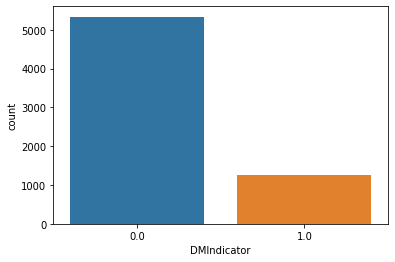

In [119]:
# Distributions of diabetes patients in the training dataset
sns.countplot(training.DMIndicator)

In [120]:
diabetes = training.loc[training.DMIndicator == 1, :]
non_diabetes = training.loc[training.DMIndicator == 0, :]

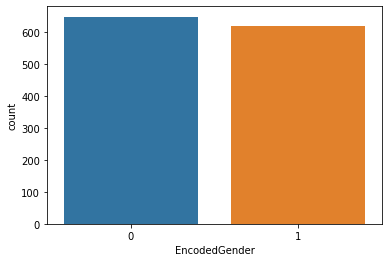

In [121]:
# Distribution for diabetes based on gender
sns.countplot(diabetes.EncodedGender)

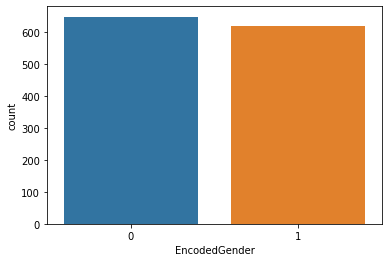

In [122]:
# Distribution for non_diabetes based on gender
sns.countplot(diabetes.EncodedGender)

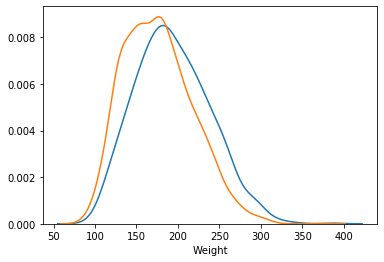

In [123]:
# Distribution for diabetes based on weight
sns.distplot(diabetes.Weight, hist = False)
sns.distplot(non_diabetes.Weight, hist = False)

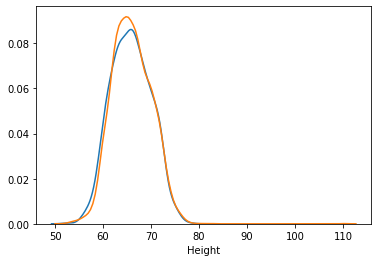

In [124]:
# Distribution for diabetes based on height
sns.distplot(diabetes.Height, hist = False)
sns.distplot(non_diabetes.Height, hist = False)

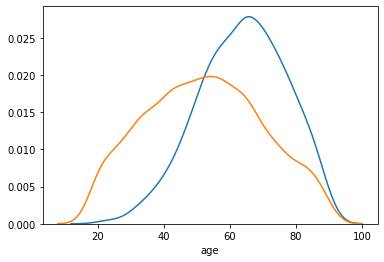

In [125]:
# Distribution for diabetes based on age
sns.distplot(diabetes.age, hist = False)
sns.distplot(non_diabetes.age, hist = False)

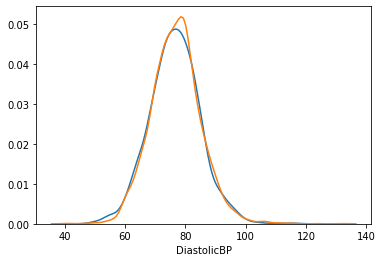

In [126]:
# Distribution for diabetes based on DiastolicBP
sns.distplot(diabetes.DiastolicBP, hist = False)
sns.distplot(non_diabetes.DiastolicBP, hist = False)

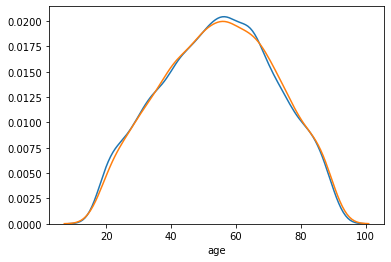

In [127]:
# Distribution for age (train vs. test)
sns.distplot(training.age, hist = False)
sns.distplot(test.age, hist = False)

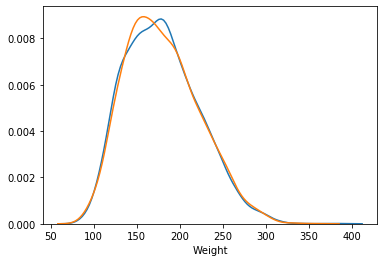

In [128]:
# Distribution for weight (train vs. test)
sns.distplot(training.Weight, hist = False)
sns.distplot(test.Weight, hist = False)

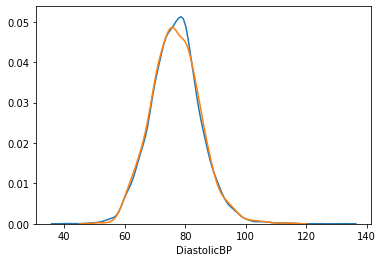

In [129]:
# Distribution for DiastolicBP (train vs. test)
sns.distplot(training.DiastolicBP, hist = False)
sns.distplot(test.DiastolicBP, hist = False)

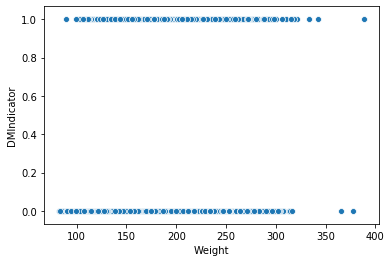

In [130]:
sns.scatterplot(training.Weight, training.DMIndicator)

## Feature Importances

In [131]:
# feature importance
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_fill = imputer.fit_transform(X_train)
rf = RandomForestClassifier(n_estimators=500, random_state = SEED)
rf.fit(X_train_fill, y_train)
feature_list = list(X_train.columns)
importances = list(rf.feature_importances_)
feature_importances = [(feature, importance) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

['Variable: BMI                  Importance: 0.05421961603314808',
 'Variable: age                  Importance: 0.05050787718117453',
 'Variable: NdcFe                Importance: 0.04516013635540501',
 'Variable: Weight               Importance: 0.0450747593244892',
 'Variable: DiastolicBP          Importance: 0.04355481824821144',
 'Variable: diseases of the circulatory system Importance: 0.04329187592653415',
 'Variable: SystolicBP           Importance: 0.04102125728227949',
 'Variable: NumberOfMedication   Importance: 0.036281614641430544',
 'Variable: endocrine, nutritional and metabolic diseases, and immunity disorders Importance: 0.03600084254176605',
 'Variable: YearlyMedQuantity    Importance: 0.035590373456934624',
 'Variable: Temperature          Importance: 0.033879540435617014',
 'Variable: NumOfYearlyVisit     Importance: 0.032866892444534085',
 'Variable: Height               Importance: 0.03284346745188905',
 'Variable: YearlyRefill         Importance: 0.0307661906630504

Text(0.5, 1.0, 'Cumulative Importances')

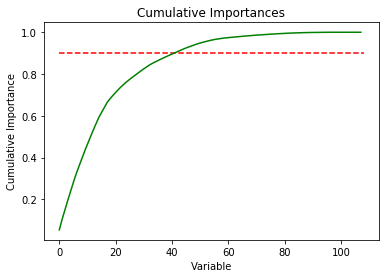

In [132]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Make a line graph
plt.plot(list(range(len(importances))), cumulative_importances, 'g-')
# Draw line at 90% of importance retained
plt.hlines(y = 0.9, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')
# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances')

In [133]:
# Find number of features for cumulative importance of 95%
print('Number of features for 90% importance:', np.where(cumulative_importances > 0.9)[0][0] + 1)

Number of features for 90% importance: 42


In [134]:
pca = PCA(n_components = 3)
X_train_fill = pca.fit_transform(X_train_fill)
pca.explained_variance_ratio_.cumsum()

array([0.97034321, 0.98946291, 0.9929939 ])

## Build the Model

For this project, I will try 3 models: Logistic Regression, Random Forest, and XGBoost.

### Logistic Regression

In [143]:
# impute missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# Standardize the data
scaler = StandardScaler()
# pca
pca = PCA(n_components = 3, random_state = SEED)
# build the model
logreg = LogisticRegression(random_state = SEED)
# build the pipeline
pipeline2 = Pipeline([('imp', imputer), ('scaler', scaler), ('PCA', pca), ('classifier', logreg)])
# cv
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state = SEED)
# param grid
random_grid = {'classifier__penalty' : ['l1', 'l2'],
               'classifier__C' : np.logspace(-4, 4, 20)}
# random search
model2 = RandomizedSearchCV(pipeline2, param_distributions = random_grid, scoring = 'brier_score_loss', cv = kfold, n_iter = 100, n_jobs=-1, random_state = SEED)
# fit on training data
model2 = model2.fit(X_train, y_train)
# brier score
y_proba = model2.predict_proba(X_test)
score2 = brier_score_loss(y_test, y_proba[:, 1])
score2

0.14910659033187032

In [144]:
# check overfitting
score_cv_lr = brier_score_loss(y_train, model2.predict_proba(X_train)[:, 1])
score_cv_lr

0.1487920023422144

### Random Forest

In [145]:
# impute missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# Standardize the data
scaler = StandardScaler()
# pca
pca = PCA(n_components = 3, random_state = SEED)
# cv
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state = SEED)
# build the model
rfc = RandomForestClassifier(n_jobs=-1, random_state=SEED)
# build the pipeline
pipeline4 = Pipeline([('imp', imputer), ('scaler', scaler), ('PCA', pca), ('classifier', rfc)])
# param grid
random_grid = {'classifier__n_estimators': stats.randint(500, 1000),
               'classifier__max_features': ['auto', 'sqrt'],
               'classifier__max_depth': stats.randint(3, 6),
               'classifier__min_samples_split': stats.randint(2, 10),
               'classifier__min_samples_leaf': stats.randint(1, 5)}
# random search
model4 = RandomizedSearchCV(pipeline4, param_distributions = random_grid, scoring = 'brier_score_loss', cv = kfold, n_iter = 100, n_jobs=-1, random_state = SEED)
# fit on training data
model4 = model4.fit(X_train, y_train)
# brier score
y_proba = model4.predict_proba(X_test)
score4 = brier_score_loss(y_test, y_proba[:, 1])
score4

0.14499830839906477

In [146]:
score_cv_rf = brier_score_loss(y_train, model4.predict_proba(X_train)[:, 1])
score_cv_rf

0.13720946921254898

In [147]:
model4.best_params_

{'classifier__max_depth': 5,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 3,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 763}

### XGBoost

In [161]:
# impute missing values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
# Standardize the data
scaler = StandardScaler()
# pca
pca = PCA(n_components = 3, random_state = SEED)
# build the model
xgb = XGBClassifier(objective='binary:logistic', early_stopping_rounds=10, n_jobs=-1, random_state=SEED)
# build the pipeline
pipeline6 = Pipeline([('imp', imputer), ('scaler', scaler), ('PCA', pca), ('classifier', xgb)])
# cv
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state = SEED)
# param grid
random_params = {'classifier__n_estimators': stats.randint(500, 1000),
                 'classifier__learning_rate': stats.uniform(0.01, 0.1),
                 'classifier__max_depth': stats.randint(3, 7),
                 'classifier__min_child_weight': stats.randint(1, 6),
                 'classifier__gamma': stats.uniform(0, 5),
                 'classifier__reg_alpha':stats.uniform(0, 1),
                 'classifier__reg_lambda':stats.uniform(1, 5)}
# random search
model6 = RandomizedSearchCV(pipeline6, param_distributions = random_params, scoring = 'brier_score_loss', cv = kfold, n_iter = 100, n_jobs=-1, random_state = SEED)
# fit on training data
model6 = model6.fit(X_train, y_train)
# brier score
y_proba = model6.predict_proba(X_test)
score6 = brier_score_loss(y_test, y_proba[:, 1])
score6

0.14506084596889007

In [162]:
score_cv_xgb = brier_score_loss(y_train, model6.predict_proba(X_train)[:, 1])
score_cv_xgb

0.1377415656274969

In [163]:
model6.best_params_

{'classifier__gamma': 1.8614138328087155,
 'classifier__learning_rate': 0.10401334424577784,
 'classifier__max_depth': 3,
 'classifier__min_child_weight': 5,
 'classifier__n_estimators': 901,
 'classifier__reg_alpha': 0.16080805141749865,
 'classifier__reg_lambda': 3.7436689468329307}

In [164]:
test_pred = model6.predict_proba(test)
DMIndicatorForecast = pd.DataFrame(test_pred[:, 1])
PatientGuid = pd.DataFrame(test.index)
output = PatientGuid.join(DMIndicatorForecast)
output.columns = ['PatientGuid', 'DMIndicatorForecast']

In [165]:
output

,PatientGuid,DMIndicatorForecast
0,027AC271-0852-4DDD-99C2-A74FE50066E0,0.090287
1,C5D4C6FA-A2B3-4CCD-A8D5-A760127CE47D,0.118527
2,1F4D1486-7632-4576-AC92-A760680D1DC9,0.180929
3,0F6AD971-F133-4BD7-B508-A76788D9C46C,0.305144
4,1E23496C-7AAF-4A91-AAF4-A769BD439E67,0.196743
...,...,...
3343,96C0A4E6-1E3E-497E-9C4E-FFEC0E25AD3A,0.219173
3344,5845977A-3014-4301-92B3-FFF0A2EBBAD2,0.029728
3345,F948403A-ABE6-496D-B37D-FFF9A9D79767,0.089306
3346,F764BC86-0CFA-4661-8D84-FFFA8E2B6080,0.286544


In [ ]:
output.to_csv('test_SyncPatientForecast.csv')